## 1. Importing libraries and download data

In [1]:
from yahoo_fin import stock_info as si
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import datetime
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set plotting style
plt.style.use('ggplot')
sns.set(style='whitegrid')

In [3]:
# Set random seed for reproducibility
np.random.seed(42)

In [4]:
# Get today's date, if not available, get data up til yesterday from now
end_date = datetime.datetime.now() - datetime.timedelta(days=1)

In [5]:
# Get start date (1 year ago)
start_date = end_date - datetime.timedelta(days=365)

In [6]:
print(f"Data downloaded from period {start_date} to {end_date}..")

Data downloaded from period 2024-05-21 16:11:44.262072 to 2025-05-21 16:11:44.262072..


In [10]:
# Get data
ticker = 'SMCI'

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"
}

data = si.get_data(
    ticker,
    start_date=start_date,
    end_date=end_date,
    headers=headers
)

data.head()

,open,high,low,close,adjclose,volume,ticker
2024-05-21,88.900002,93.994003,87.777000,89.894997,89.894997,59188000,SMCI
2024-05-22,91.012001,91.165001,86.250999,87.327003,87.327003,56322000,SMCI
2024-05-23,93.448997,97.231003,83.566002,84.737999,84.737999,114602000,SMCI
2024-05-24,85.800003,89.919998,83.861000,88.388000,88.388000,68504000,SMCI
2024-05-28,89.900002,90.964996,86.500000,87.472000,87.472000,62351000,SMCI


In [12]:
# Show the first few rows of the data
print(f"Data shape: {data.shape}")
print(f"Date range: {data.index.min()} to {data.index.max()}")

Data shape: (251, 7)
Date range: 2024-05-21 00:00:00 to 2025-05-21 00:00:00


## Calculating metrics and historical percentiles

In [14]:
# Calculate the log returns
prices = data['adjclose'].values
log_returns = np.log(prices[1:]/prices[:-1])

In [15]:
# Calculate the mean and standard deviation of log returns
mu = np.mean(log_returns)
sigma = np.std(log_returns)

print(f"Mean of log returns (mu): {mu:.6f}")
print(f"Standard deviation of log returns (sigma): {sigma:.6f}")

Mean of log returns (mu): -0.003077
Standard deviation of log returns (sigma): 0.072177


In [16]:
# Calculate the percentiles for entry and exit points
P10 = np.percentile(prices, 10)
P50 = np.percentile(prices, 50)
P75 = np.percentile(prices, 75)

print(f"P10 (Entry point): ${P10:.2f}")
print(f"P50 (Partial exit): ${P50:.2f}")
print(f"P75 (Final exit): ${P75:.2f}")

P10 (Entry point): $30.05
P50 (Partial exit): $41.94
P75 (Final exit): $57.23


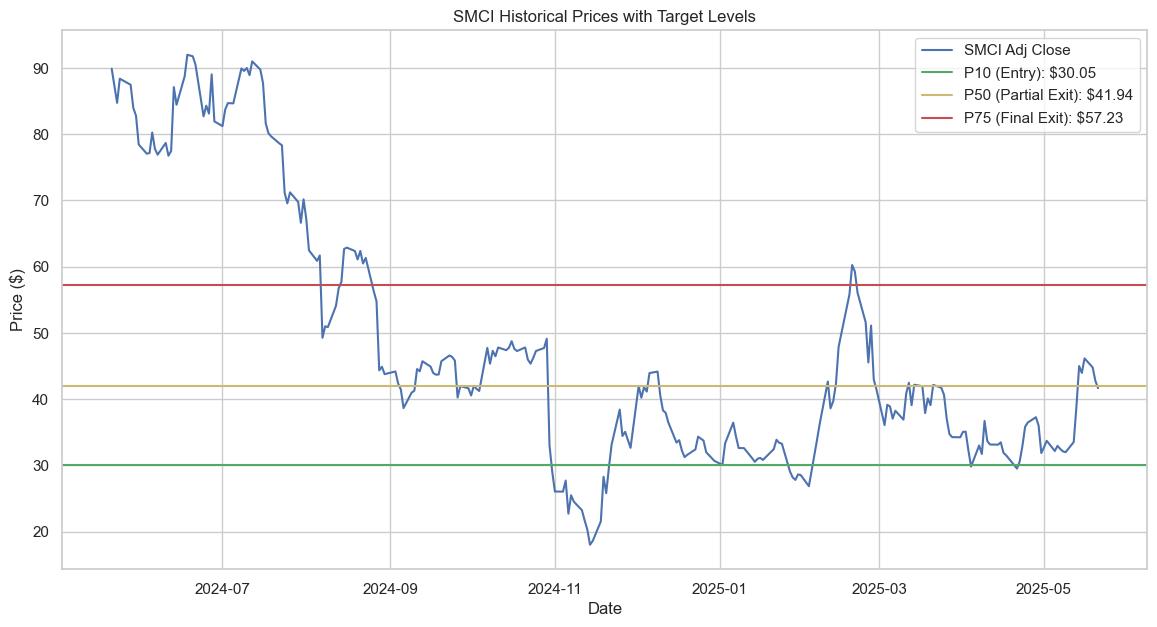

In [17]:
# Plot the historical prices with percentile lines
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['adjclose'], label=f'{ticker} Adj Close')
plt.axhline(y=P10, color='g', linestyle='-', label=f'P10 (Entry): ${P10:.2f}')
plt.axhline(y=P50, color='y', linestyle='-', label=f'P50 (Partial Exit): ${P50:.2f}')
plt.axhline(y=P75, color='r', linestyle='-', label=f'P75 (Final Exit): ${P75:.2f}')
plt.title(f'{ticker} Historical Prices with Target Levels')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.savefig('historical_prices_with_targets.png', dpi=300, bbox_inches='tight')

## 3. Running Monte Carlo Simulation

In [18]:
# Define simulation parameters
days = 90  # time horizon
dt = 1/252  # daily time step (1/252 trading days in a year)
num_simulations = 1000  # number of simulations

# Get the most recent price as the starting point
S0 = prices[-1]

# Initialize the array to store all simulation paths
simulation_df = pd.DataFrame()

# Run the Monte Carlo simulation
for i in range(num_simulations):
    # Generate array of random standard normal values
    Z = np.random.standard_normal(days)

    # Initialize price array
    price_path = np.zeros(days)
    price_path[0] = S0

    # Generate the price path
    for t in range(1, days):
        price_path[t] = price_path[t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[t])

    # Store the simulation path
    simulation_df[f'Sim_{i}'] = price_path

simulation_df.head()

,Sim_0,Sim_1,Sim_2,Sim_3,Sim_4,Sim_5,Sim_6,Sim_7,Sim_8,Sim_9,...,Sim_990,Sim_991,Sim_992,Sim_993,Sim_994,Sim_995,Sim_996,Sim_997,Sim_998,Sim_999
0,41.650002,41.650002,41.650002,41.650002,41.650002,41.650002,41.650002,41.650002,41.650002,41.650002,...,41.650002,41.650002,41.650002,41.650002,41.650002,41.650002,41.650002,41.650002,41.650002,41.650002
1,41.622888,41.832897,41.487061,41.378043,41.940327,41.830328,41.435681,41.939719,41.326468,41.565875,...,41.541781,41.851270,41.522585,41.482944,41.868042,41.383420,41.532013,41.585732,41.813310,41.442768
2,41.744701,41.698637,41.284617,41.596516,41.918647,41.642332,41.534679,41.908654,41.072992,41.839296,...,41.859162,41.979603,41.505783,41.467501,41.833393,41.093609,41.475515,41.506461,42.014881,41.310674
3,42.033831,41.635622,41.374349,41.597514,41.994334,41.736935,41.806866,41.826449,41.211101,41.875760,...,41.796783,41.757864,41.650164,41.555836,41.903766,41.116385,41.418001,41.676081,42.176338,41.215269
4,41.988157,41.560522,41.331401,41.411358,42.125365,41.635492,41.338742,41.633476,41.242199,42.071734,...,41.710324,41.727873,41.624929,41.647502,41.821936,41.106448,41.263969,41.648500,42.116236,41.429849


In [20]:
simulation_df.tail()

,Sim_0,Sim_1,Sim_2,Sim_3,Sim_4,Sim_5,Sim_6,Sim_7,Sim_8,Sim_9,...,Sim_990,Sim_991,Sim_992,Sim_993,Sim_994,Sim_995,Sim_996,Sim_997,Sim_998,Sim_999
85,39.611188,41.738465,41.304088,42.496200,43.034566,39.048204,43.310967,40.221433,41.562436,46.208679,...,39.895635,45.176256,43.366580,42.620691,40.710531,41.305186,38.500959,43.969554,40.359966,42.708260
86,39.775500,41.739992,41.610855,42.491665,43.105385,38.894866,43.115556,40.241421,41.603496,46.172540,...,40.106992,45.205195,43.204703,42.893635,40.606143,41.548296,38.465992,43.955168,40.264247,42.577489
87,39.834100,42.015811,41.340227,42.434976,42.920604,38.826043,43.089933,40.268023,41.512099,46.202309,...,40.317278,45.050123,43.410528,42.884798,40.732017,41.687467,38.360582,43.482634,40.055529,42.519191
88,39.737372,41.964336,41.256668,42.496329,42.819475,39.003214,43.099880,40.200598,41.748852,46.455409,...,40.265430,45.258270,43.566377,43.119262,40.839938,42.024661,38.335069,43.592311,40.612059,42.568447
89,39.829317,42.485611,41.280269,42.335837,42.612793,38.900166,43.313860,40.189285,41.578444,46.282132,...,40.359743,45.305335,43.576669,43.064164,41.155224,41.985948,38.260104,43.391633,40.644870,42.529488


In [19]:
# Calculate final prices for each simulation
final_prices = simulation_df.iloc[-1].values

# Calculate the probability of reaching the targets
prob_P50 = np.mean(final_prices >= P50)
prob_P75 = np.mean(final_prices >= P75)

print(f"Probability of reaching P50 (${P50:.2f}) in 90 days: {prob_P50:.2%}")
print(f"Probability of reaching P75 (${P75:.2f}) in 90 days: {prob_P75:.2%}")

Probability of reaching P50 ($41.94) in 90 days: 42.00%
Probability of reaching P75 ($57.23) in 90 days: 0.00%


## 4. Visualizing simulation results

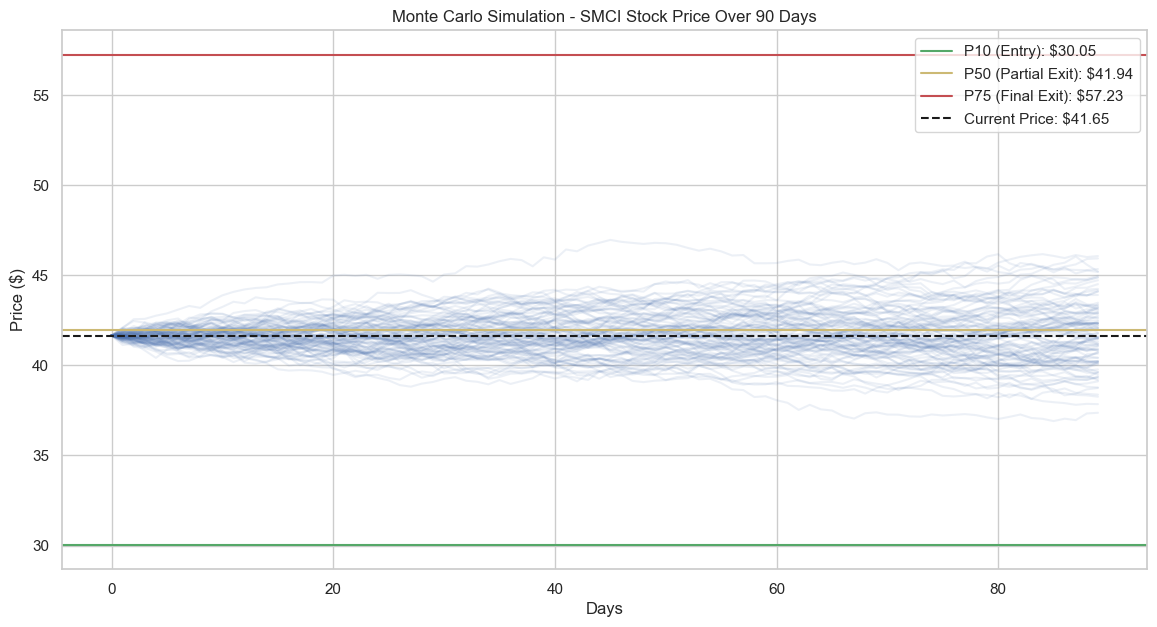

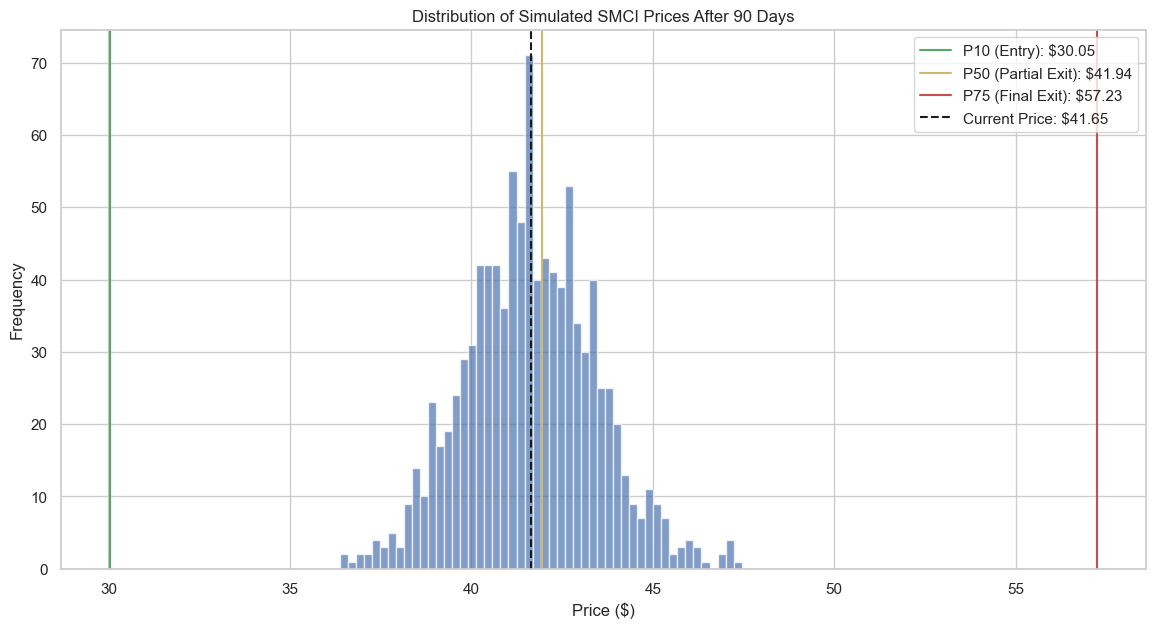

In [21]:
# Plot the Monte Carlo simulation paths
plt.figure(figsize=(14, 7))

# Plot a subset of paths for clarity
subset_size = 100
subset_indices = np.random.choice(num_simulations, subset_size, replace=False)
for i in subset_indices:
    plt.plot(simulation_df[f'Sim_{i}'], 'b-', alpha=0.1)

# Plot the percentile lines
plt.axhline(y=P10, color='g', linestyle='-', label=f'P10 (Entry): ${P10:.2f}')
plt.axhline(y=P50, color='y', linestyle='-', label=f'P50 (Partial Exit): ${P50:.2f}')
plt.axhline(y=P75, color='r', linestyle='-', label=f'P75 (Final Exit): ${P75:.2f}')
plt.axhline(y=S0, color='k', linestyle='--', label=f'Current Price: ${S0:.2f}')

# Add labels and title
plt.title(f'Monte Carlo Simulation - {ticker} Stock Price Over {days} Days')
plt.xlabel('Days')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.savefig('monte_carlo_simulation.png', dpi=300, bbox_inches='tight')

# Plot the histogram of final prices
plt.figure(figsize=(14, 7))
plt.hist(final_prices, bins=50, alpha=0.7)
plt.axvline(x=P10, color='g', linestyle='-', label=f'P10 (Entry): ${P10:.2f}')
plt.axvline(x=P50, color='y', linestyle='-', label=f'P50 (Partial Exit): ${P50:.2f}')
plt.axvline(x=P75, color='r', linestyle='-', label=f'P75 (Final Exit): ${P75:.2f}')
plt.axvline(x=S0, color='k', linestyle='--', label=f'Current Price: ${S0:.2f}')
plt.title(f'Distribution of Simulated {ticker} Prices After {days} Days')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.savefig('final_price_distribution.png', dpi=300, bbox_inches='tight')